In [1]:
import pandas as pd #data manipulation
import seaborn as sns #statistical visualization
import matplotlib.pyplot as plt #visualization
from sklearn.cluster import KMeans #algorithm to create clusters
from sklearn.feature_extraction.text import CountVectorizer #extract most common words
from sklearn.feature_extraction.text import TfidfVectorizer #extract most important words
from sklearn.decomposition import PCA #dimension reduction
from IPython.display import display #display function
from IPython.display import clear_output #output
import ipywidgets as widgets 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings

In [3]:
df = pd.read_csv("~/Desktop/movie-recommender/movies_info.csv") 

In [4]:
df.head() 

,original_title,overview,genres
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"['Drama', 'Crime']"
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","['Drama', 'Crime']"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"['Drama', 'Crime']"
3,Schindler's List,The true story of how businessman Oskar Schind...,"['Drama', 'History', 'War']"
4,12 Angry Men,The defense and the prosecution have rested an...,['Drama']


In [5]:
#Univarite Analysis

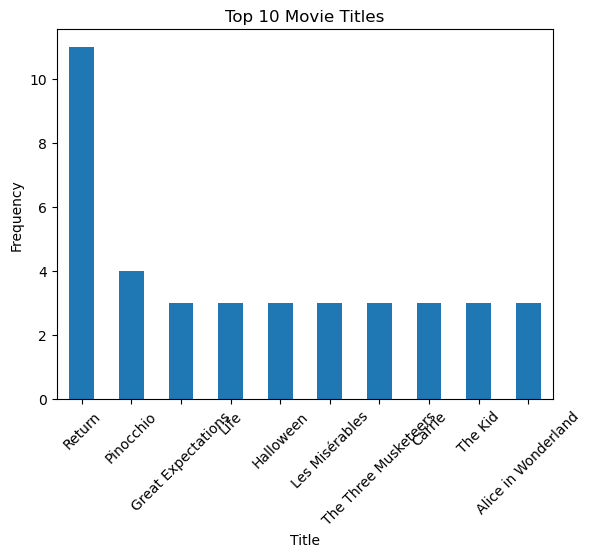

In [6]:
#top 10 movie titles (original title)
df['original_title'].value_counts().head(10).plot(kind='bar', title='Top 10 Movie Titles')
plt.xlabel("Title")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

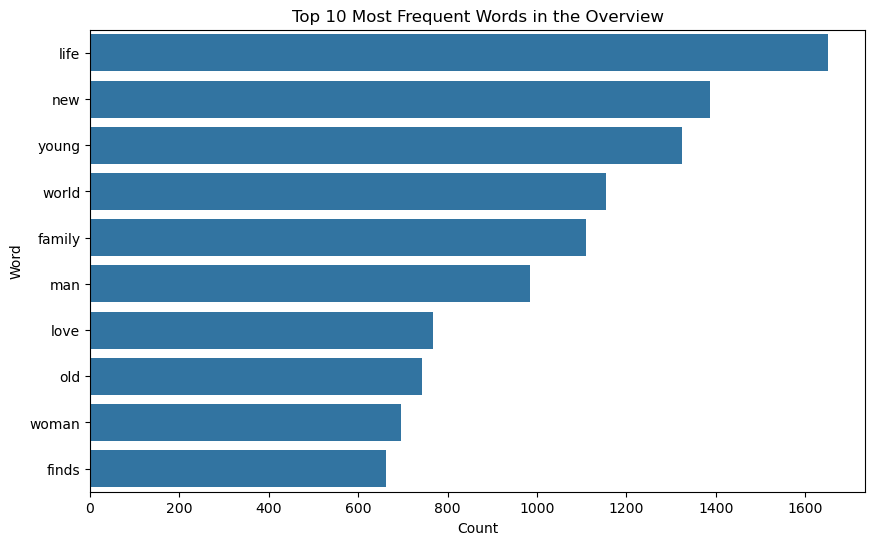

In [7]:
#top 10 most frequent words in the overview
overviews = df['overview'].dropna() #drop missing overviews
#convert text into word frequency matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(overviews) 
#sum word counts
word_count = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
word_freq = pd.DataFrame({'word' : words, 'count' : word_count})
word_freq = word_freq.sort_values(by = 'count', ascending = False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data = word_freq, x = 'count', y = 'word')
plt.title("Top 10 Most Frequent Words in the Overview")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

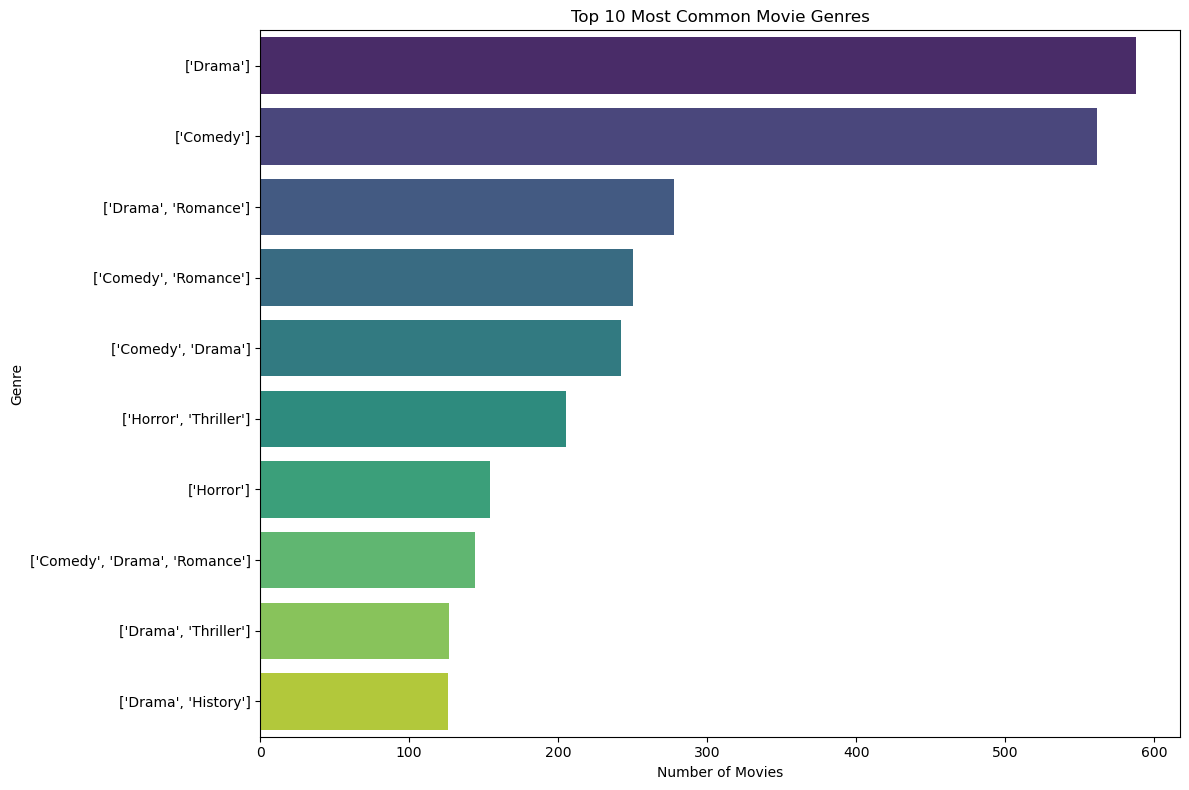

In [8]:
#Most common genres
df['genres'] = df['genres'].astype(str) #convert to string
df['genres'] = df['genres'].str.split('|') #split the strings
df_exploded = df.explode('genres') #one genre per row
df_exploded['genres'] = df_exploded['genres'].str.strip() #remove blanks
df_exploded = df_exploded[df_exploded['genres'] !=""] #drop empty
genre_counts = df_exploded['genres'].value_counts() #genre count
plt.figure(figsize=(12,8))
sns.barplot(x = genre_counts.head(10).values, y = genre_counts.head(10).index, palette = "viridis")
plt.title("Top 10 Most Common Movie Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

In [9]:
#Create Clusters by grouping important words
df = df.dropna(subset = ['overview']) #drop null values
df_clean = df.dropna(subset=['overview']).copy() #clean copy so original is not modifidied
#TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words = 'english', max_features = 5000) #into numerical matrix to pick out 5000 important words
X_tfidf = tfidf.fit_transform(df['overview']) #transforms overview into TF-IDF matrix
#Clustering
kmeans = KMeans(n_clusters=10, random_state = 42) #10 clusters in the KMeans clustering model
kmeans.fit(X_tfidf) #find clusters
#Label clusters
df['cluster'] = kmeans.labels_ #adds a new column clusters


In [10]:
df.head()

,original_title,overview,genres,cluster
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[['Drama', 'Crime']]",4
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[['Drama', 'Crime']]",8
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[['Drama', 'Crime']]",8
3,Schindler's List,The true story of how businessman Oskar Schind...,"[['Drama', 'History', 'War']]",6
4,12 Angry Men,The defense and the prosecution have rested an...,[['Drama']],2


In [11]:
#Bivariate Analysis

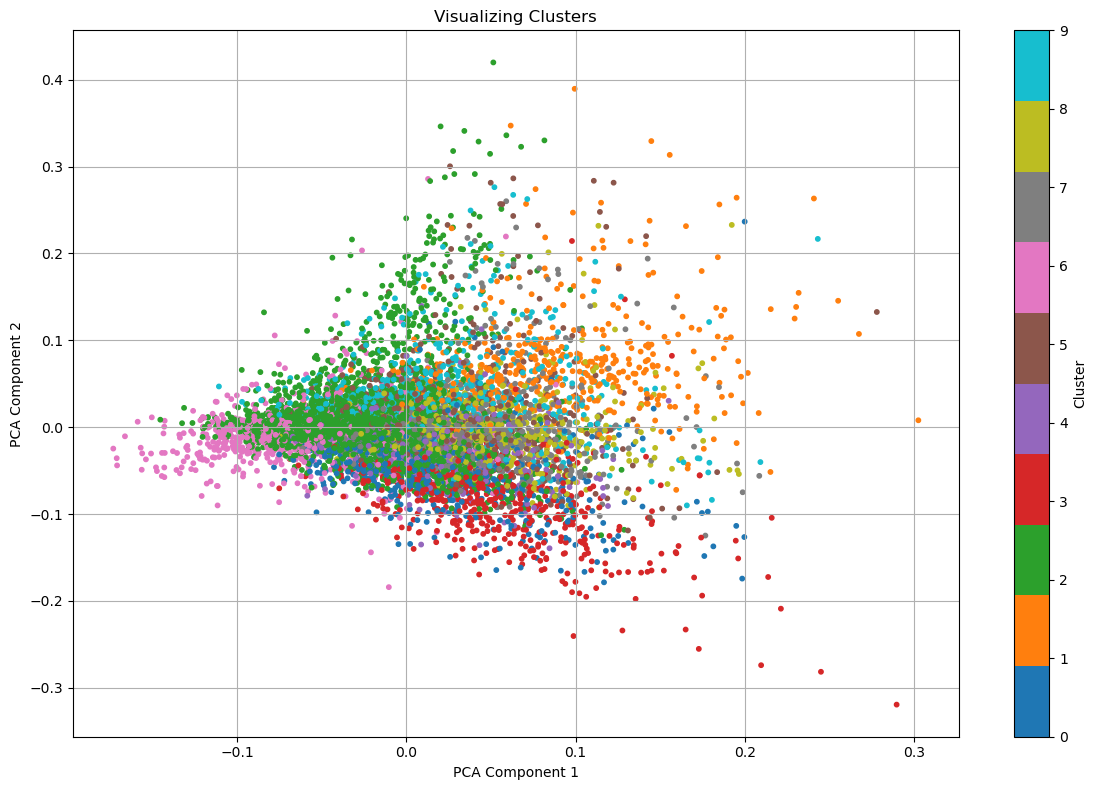

In [12]:
#Plotting Clusters
pca = PCA(n_components = 2) #2D
tfidf_matrix = tfidf.fit_transform(df['overview'])
reduced_data = pca.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize = (12, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:,1], c = kmeans.labels_, cmap = 'tab10', s = 10)
plt.title("Visualizing Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label = 'Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
#Cluster Topics
cluster_keywords = [] #list
for cluster_num in sorted(df['cluster'].unique()):
    texts = df[df['cluster'] == cluster_num]['overview'].dropna().tolist()
    vectorizer1 = CountVectorizer(stop_words = 'english', max_features = 50)
    X1 = vectorizer1.fit_transform(texts)
    word_counts = X1.sum(axis = 0).A1
    words = vectorizer1.get_feature_names_out()
    top_indices = word_counts.argsort()[-5:][::-1]
    top_words = [words[i] for i in top_indices]
    cluster_keywords.append((cluster_num, ", ".join(top_words)))
topic_summary = pd.DataFrame(cluster_keywords, columns = ['Cluster','Top Words'])
topic_summary.set_index('Cluster', inplace=True) #removes index
display(topic_summary)

,Top Words
Cluster,
0,"man, young, life, family, love"
1,"old, year, life, family, new"
2,"young, time, group, school, love"
3,"woman, young, life, love, man"
4,"wife, life, son, daughter, man"
5,"mother, friend, best, friends, father"
6,"world, war, young, ii, story"
7,"life, young, new, love, years"
8,"family, life, home, new, young"


In [14]:
#Recommendation
#Search box
search_input = widgets.Text(
    placeholder = 'Type a movie name:',
    description = 'Search:',
    layout = widgets.Layout(width = '500px'))
#search button
search_button = widgets.Button(description = "Search")
#output
output = widgets.Output()
def recommend_movies(title, df, n = 5):
    title = title.strip().lower() #strip whitespace and lowercase
    matches = df[df['original_title'].str.lower().str.contains(title)] #finds the title with the words typed into the search box
    
    with output:
        clear_output()
         #if no matches 
        if matches.empty:
            print("No matches")
            return
    
        first_match = matches.iloc[0] #first match
        cluster = first_match['cluster'] #find cluster
        similar_movies = df[(df['cluster'] == cluster) & (df['original_title'] != first_match['original_title'])] #select the movies in the same subset but not the one already selected

   
        print(f"\n Movies similar to {first_match['original_title']}")
        display(similar_movies[['original_title', 'overview']].head(n))


def on_search_clicked(b):
    recommend_movies(search_input.value, df)
search_button.on_click(on_search_clicked)
display(widgets.VBox([widgets.HBox([search_input, search_button]), output])) #display

In [ ]:
df.to_csv("clustered_movies.csv", index = False)